# Find cluster related terms using LIME

---
## Load the data

In [1]:
root_dir = '../..'
data_dir = 'data'
corpus_dir = 'corpus'
src_dir = 'src'

In [2]:
import os 
import sys

In [3]:
sys.path.append(os.path.join(root_dir, src_dir))

In [4]:
corpus_filename = 'reuters_corpus.json'
corpus_filepath = os.path.join(root_dir, data_dir, corpus_dir, corpus_filename)

In [5]:
chunks_filename = 'reuters_chunks.json'
chunks_filepath = os.path.join(root_dir, data_dir, corpus_dir, chunks_filename)

In [6]:
from training import TrainingCorpus

In [7]:
reuters_corpus = TrainingCorpus()
reuters_corpus.load(corpus_filepath)
reuters_corpus.load_chunks(chunks_filepath)

---
## Load the model

In [8]:
from model import TensorflowModel

Using TensorFlow backend.


In [9]:
models_dir = 'models'

In [10]:
model_filename = 'reuters_nn_model.h5'
model_filepath = os.path.join(root_dir, data_dir, models_dir, model_filename)

In [11]:
word_index_filename = 'reuters_nn_word_index.csv'
word_index_filepath = os.path.join(root_dir, data_dir, models_dir, word_index_filename)

In [12]:
nn_model = TensorflowModel(model_filepath, word_index_filepath)

/home/nvidia/anaconda3/envs/testenv/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


---
## Sample data
### Load the embedding model

In [13]:
from keras.models import load_model
from keras.models import Model

In [14]:
tf_model = load_model(model_filepath)

First of all we need to load a subset of `tf_model` such that the last layer is the LSTM layer. Using this neural network we can get for each input its corresponding embedding.

In [15]:
print('Index\tLayer')
print('-------------------------')
for index, layer in enumerate(tf_model.layers):
    print(index,'\t',layer.name)

Index	Layer
-------------------------
0 	 input_1
1 	 embedding_1
2 	 bidirectional_1
3 	 dense_1
4 	 dense_2


In [16]:
embedding_model = Model(tf_model.input, tf_model.get_layer(index=2).output)

Plot the model

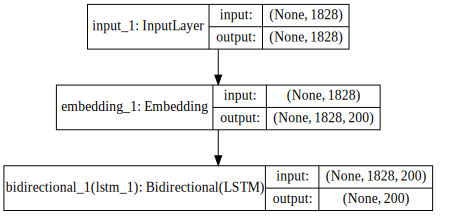

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(embedding_model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

### Retrieve embeddings using the embedding model

In [18]:
import numpy as np
import pandas as pd

In [19]:
word_index_df = pd.read_csv(word_index_filepath, index_col='term')
word_to_idx_map = word_index_df.to_dict()['index']

In [20]:
from keras.preprocessing.sequence import pad_sequences

def tokens_to_sequence(tokens, word_to_idx_map, maxlen):
    sequence = []
    for token in tokens:
        if token in word_to_idx_map:
            token_idx = word_to_idx_map[token]
            sequence.append(token_idx)
    
    padded_sequence = pad_sequences([sequence], maxlen=maxlen).reshape(-1)
    return padded_sequence

Get model input size

In [21]:
maxlen = tf_model.input.shape[1]
maxlen

1828

Build the embedding matrix

In [22]:
doc_sequences = []

In [23]:
for doc_id in reuters_corpus.docs:
    doc_tokens = reuters_corpus.get_tokens(doc_id)
    doc_sequence = tokens_to_sequence(doc_tokens, word_to_idx_map, maxlen)
    doc_sequences.append(doc_sequence)

In [24]:
doc_sequences_np = np.array(doc_sequences)
doc_sequences_np.shape

(9848, 1828)

In [25]:
embedding_matrix = embedding_model.predict(doc_sequences_np)
embedding_matrix.shape

(9848, 200)

### Sample documents using K-means

In [26]:
label_to_data_idx_map = nn_model.label_to_data_idx(reuters_corpus)

In [28]:
from sample import KMeansSampler

sampler = KMeansSampler(reuters_corpus, 
                        embedding_matrix,
                        label_to_data_idx_map,
                        min_size=500,
                        max_size=2000)

Utility function used for sampling data for each concept

In [29]:
def sample_data_mp(sampler, label_idx):
    sample_data_idxs = sampler.sample_data(label_idx)
    return (label_idx, sample_data_idxs)

Get the number of available CPU cores

In [30]:
import psutil

In [31]:
psutil.cpu_count(logical=False)

22

Set the number of parallel job for the sampling step

In [32]:
kmeans_jobs = 8

Finally, sample the data

In [33]:
from joblib import Parallel, delayed

In [34]:
label_to_sample_idxs = Parallel(n_jobs=kmeans_jobs, verbose=10)(delayed(sample_data_mp)(sampler, label_idx) for label_idx in label_to_data_idx_map)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    7.9s
[Parallel(n_jobs=8)]: Done   8 out of  20 | elapsed:   12.5s remaining:   18.7s
[Parallel(n_jobs=8)]: Done  11 out of  20 | elapsed:   16.3s remaining:   13.4s
[Parallel(n_jobs=8)]: Done  14 out of  20 | elapsed:   17.9s remaining:    7.7s
[Parallel(n_jobs=8)]: Done  17 out of  20 | elapsed:   20.1s remaining:    3.6s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  1.1min finished


---
## Find relevant terms for each cluster label using LIME

In [35]:
from termfinder import LimeTermFinder

In [36]:
def get_relevant_terms_mp(model, corpus, input_data):
    result_list = []
    
    term_finder = LimeTermFinder(model, corpus)
    
    for label_idx, data_idx in input_data:
        relevant_terms = term_finder.get_relevant_terms(data_idx, label_idx)
        
        if relevant_terms:
            
            for term, weight in relevant_terms.items():
                dict_entry = {'label': corpus.labels[label_idx],
                              'term': term,
                              'weight': weight,
                              'data_id': corpus.docs[data_idx]}
                result_list.append(dict_entry)
    
    return result_list

### Split the data into multiple batches

In [37]:
import numpy as np

Slice input data into batches

In [38]:
input_data = np.array([(label_idx, data_idx) for label_idx, data_idxs in label_to_sample_idxs for data_idx in data_idxs])

Set the number of parallel jobs

In [39]:
lime_jobs = 14

Compute batches

In [40]:
input_slices = np.array_split(input_data, lime_jobs)

Finally, find relevant terms using `LIME`

In [41]:
terms_list_tmp = Parallel(n_jobs=lime_jobs, verbose=10, batch_size=1)(delayed(get_relevant_terms_mp)(nn_model, reuters_corpus, input_batch) for input_batch in input_slices)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/nvidia/anaconda3/envs/testenv/lib/python3.8/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/nvidia/anaconda3/envs/testenv/lib/python3.8/site-packages/joblib/externals/loky/backend/synchronize.py", line 96, in _cleanup
    sem_unlink(name)
FileNotFoundError: [Errno 2] No such file or directory
Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/nvidia/anaconda3/envs/testenv/lib/python3.8/multiprocessing/util.py", line 201, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/nvidia/anaconda3/envs/testenv/lib/python3.8/site-packages/joblib/externals/loky/backend/synchronize.py", line 96, in _cleanup
    sem_unlink(name)
FileNotFoundError: [Errno 2] No such file or directory
[Parallel

Build a DataFrame out of `terms_list_tmp`

In [43]:
df_data = []
for sublist in terms_list_tmp:
    df_data += sublist

In [44]:
df_data[:3]

[{'label': 'earn',
  'term': '15_cts',
  'weight': 0.039050247438999125,
  'data_id': 3405},
 {'label': 'earn',
  'term': 'div',
  'weight': 0.03501927337817323,
  'data_id': 3405},
 {'label': 'earn',
  'term': 'payout',
  'weight': 0.034544346395799584,
  'data_id': 3405}]

In [ ]:
relevant_terms_df = pd.DataFrame(df_data)

In [ ]:
relevant_terms_df.head()

---
## Save retrieved terms to a file

In [ ]:
terms_dir = 'terms'
filename = 'relevant_terms_reuters_nn.csv'
filepath = os.path.join(root_dir, data_dir, terms_dir, filename)

In [ ]:
relevant_terms_df.to_csv(filepath, encoding='utf-8', index=False)

---
## Check for pending joblib processes

In [ ]:
from multiprocessing import active_children

In [ ]:
active_children()